## 1. Problem overview

The goal of this project is to build a company classifier for a new insurance taxonomy.

Input:
- A list of companies with text fields: description, business tags, sector, category, niche.
- A static insurance taxonomy: a list of possible insurance-related labels.

Output:
- For each company, one or more insurance labels from the taxonomy.

There is no ground-truth mapping provided, so I validate the approach using:
- Exploratory analysis of similarity scores.
- Manual inspection of a sample of companies.
- Clear discussion of strengths, weaknesses, and limitations of the method.

In [2]:
import os
import pandas as pd
from google.colab import files
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer





## 2. Loading the data

In this section I load the two CSV files:
- `ml_insurance_challenge.csv` – the list of companies.
- `insurance_taxonomy.csv` – the list of insurance labels.

I also quickly inspect the schema and missing values to understand how clean the data is
before doing any modeling.

In [3]:
uploaded = files.upload()

Saving insurance_taxonomy - insurance_taxonomy.csv to insurance_taxonomy - insurance_taxonomy.csv
Saving ml_insurance_challenge.csv to ml_insurance_challenge.csv


In [4]:
insurance_taxonomy = pd.read_csv('insurance_taxonomy - insurance_taxonomy.csv')
company_list = pd.read_csv('ml_insurance_challenge.csv')

display(company_list.head())
display(insurance_taxonomy.head())

,description,business_tags,sector,category,niche
0,Welchcivils is a civil engineering and constru...,"['Construction Services', 'Multi-utilities', '...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction
1,"Kyoto Vegetable Specialists Uekamo, also known...","['Wholesale', 'Dual-task Movement Products', '...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing"
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"['Living Forms', 'Farm Cafe', 'Fresh Coffee', ...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming
3,PATAGONIA Chapa Y Pintura is an auto body shop...,"['Automotive Body Repair Services', 'Interior ...",Services,Auto Body Shops,"Automotive Body, Paint, and Interior Repair an..."
4,Stanica WODNA PTTK Swornegacie is a cultural e...,"['Cultural Activities', 'Accommodation Service...",Services,Boat Tours & Cruises,"Scenic and Sightseeing Transportation, Water"


,label
0,Agricultural Equipment Services
1,Soil Nutrient Application Services
2,Pesticide Application Services
3,Ornamental Plant Nurseries
4,Landscaping Services


In [5]:
company_list.head(5)


,description,business_tags,sector,category,niche
0,Welchcivils is a civil engineering and constru...,"['Construction Services', 'Multi-utilities', '...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction
1,"Kyoto Vegetable Specialists Uekamo, also known...","['Wholesale', 'Dual-task Movement Products', '...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing"
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"['Living Forms', 'Farm Cafe', 'Fresh Coffee', ...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming
3,PATAGONIA Chapa Y Pintura is an auto body shop...,"['Automotive Body Repair Services', 'Interior ...",Services,Auto Body Shops,"Automotive Body, Paint, and Interior Repair an..."
4,Stanica WODNA PTTK Swornegacie is a cultural e...,"['Cultural Activities', 'Accommodation Service...",Services,Boat Tours & Cruises,"Scenic and Sightseeing Transportation, Water"




 3. **Data  cleaning**

This is where the actual cleaning starts.  
The first thing I wanted to check was whether I had rows with almost no useful text.

1. **Drop rows with missing key fields**  
   I inspected the columns `description`, `business_tags`, `sector`, `category`, and `niche`.
   If a row was missing information in these core text fields, I removed it.  
   Since my whole approach relies on text similarity, rows with very little or no text
   would not be classifiable in a meaningful way.

In [6]:
company_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9494 entries, 0 to 9493
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   description    9482 non-null   object
 1   business_tags  9494 non-null   object
 2   sector         9467 non-null   object
 3   category       9467 non-null   object
 4   niche          9494 non-null   object
dtypes: object(5)
memory usage: 371.0+ KB


In [7]:
company_list.isna().sum()

,0
description,12
business_tags,0
sector,27
category,27
niche,0


In [8]:
cols = ["description", "business_tags", "sector", "category", "niche"]

mask_any_na = company_list[cols].isna().any(axis=1)

company_list_clean= company_list[~mask_any_na].reset_index(drop=True)


In [9]:
company_list_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9455 entries, 0 to 9454
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   description    9455 non-null   object
 1   business_tags  9455 non-null   object
 2   sector         9455 non-null   object
 3   category       9455 non-null   object
 4   niche          9455 non-null   object
dtypes: object(5)
memory usage: 369.5+ KB


2. **Remove rows with empty business tags**  
   Some rows had `business_tags` equal to `[]`.  
   I treated these as carrying almost no extra signal and filtered them out as well.

In [10]:
mask_bt_empty = company_list_clean["business_tags"].astype(str).str.strip().eq("[]")
mask_bt_empty.sum()

company_list_cleaner = company_list_clean[~mask_bt_empty].reset_index(drop=True)



In [11]:
len(company_list_cleaner), len(company_list_cleaner)


(9093, 9093)

3. **Remove fully duplicated rows**  
   I dropped exact duplicates to avoid overweighting the same company multiple times.

In [12]:
company_list_cleaner.duplicated().sum()
company_list_cleaner = company_list_cleaner.drop_duplicates().reset_index(drop=True)



I also noticed a few cases where only a single field (for example, the description) was duplicated, while the other fields such as business_tags, category, or niche were different.  
In these situations I decided to keep all versions, to see how the model would classify slightly different metadata for the same textual description.

In [13]:
cols_check = ["description", "business_tags", "category", "niche"]

for col in cols_check:
    dup_count = company_list_cleaner[col].duplicated().sum()
    print(col, "→", dup_count, "duplicated values")

description → 3 duplicated values
business_tags → 69 duplicated values
category → 8643 duplicated values
niche → 8136 duplicated values


In [14]:
dups_desc = company_list_cleaner[company_list_cleaner["description"].duplicated(keep=False)] \
    .sort_values("description")

dups_desc

,description,business_tags,sector,category,niche
849,MVH Containerparts is a leading supplier of co...,"['Container Spare Parts', 'In-house Production...",Manufacturing,Metal Storage Tanks,Metal Can Manufacturing
4731,MVH Containerparts is a leading supplier of co...,"['Container Manufacturing', 'Container Spare P...",Manufacturing,Metal Storage Tanks,Metal Can Manufacturing
682,The company is a business analysis and English...,"['Law Firm Specializing in Insurance Law', 'Fi...",Services,Title Abstract & Settlement Offices,Title Abstract and Settlement Offices
2539,The company is a business analysis and English...,"['Historical Education', 'Historical Research'...",Services,Newspapers & Magazines,Periodical Publishers
8760,The company is a business analysis and English...,"['Research and Development', 'Management Consu...",Manufacturing,Chemicals,Industrial Gas Manufacturing


In [16]:
company_list_cleaner["business_tags"].apply(type).value_counts()


,count
business_tags,
<class 'str'>,9092


In [17]:
company_list_cleaner

,description,business_tags,sector,category,niche
0,Welchcivils is a civil engineering and constru...,"['Construction Services', 'Multi-utilities', '...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction
1,"Kyoto Vegetable Specialists Uekamo, also known...","['Wholesale', 'Dual-task Movement Products', '...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing"
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"['Living Forms', 'Farm Cafe', 'Fresh Coffee', ...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming
3,PATAGONIA Chapa Y Pintura is an auto body shop...,"['Automotive Body Repair Services', 'Interior ...",Services,Auto Body Shops,"Automotive Body, Paint, and Interior Repair an..."
4,Stanica WODNA PTTK Swornegacie is a cultural e...,"['Cultural Activities', 'Accommodation Service...",Services,Boat Tours & Cruises,"Scenic and Sightseeing Transportation, Water"
...,...,...,...,...,...
9087,"Anhui Zhongxin Electric Co., Ltd. is a high-te...","['Automation Equipment', 'Technical Consulting...",Manufacturing,Electric Supplies & Power Generation,All Other Miscellaneous Electrical Equipment a...
9088,"TP Material Co.,Ltd. is a company based in the...","['Construction Materials Supplier', 'Construct...",Services,Construction Services,Commercial and Institutional Building Construc...
9089,Aladiner Cherag is a company that offers a var...,"['Fruit And Vegetables', 'Hand Wash Products',...",Manufacturing,Dairy Products - Farms & Stores,Fluid Milk Manufacturing
9090,Candor Eeg is a medical care company located i...,"['Stress Tests', 'Hyperventilation', 'Holter M...",Services,Radiology Clinic,Diagnostic Imaging Centers


**Normalize the `business_tags` column**  
   Initially, `business_tags` was stored as a string that looked like a Python list.
   I converted it into a real list, then into a clean text string (without brackets or quotes)
   so I could concatenate it with the other text fields later.


In [18]:
company_list_copy = company_list_cleaner.copy()
company_list_copy["business_tags"] = company_list_copy["business_tags"].astype(str).str.strip("[]")
company_list_copy

,description,business_tags,sector,category,niche
0,Welchcivils is a civil engineering and constru...,"'Construction Services', 'Multi-utilities', 'U...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction
1,"Kyoto Vegetable Specialists Uekamo, also known...","'Wholesale', 'Dual-task Movement Products', 'C...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing"
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"'Living Forms', 'Farm Cafe', 'Fresh Coffee', '...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming
3,PATAGONIA Chapa Y Pintura is an auto body shop...,"'Automotive Body Repair Services', 'Interior R...",Services,Auto Body Shops,"Automotive Body, Paint, and Interior Repair an..."
4,Stanica WODNA PTTK Swornegacie is a cultural e...,"'Cultural Activities', 'Accommodation Services...",Services,Boat Tours & Cruises,"Scenic and Sightseeing Transportation, Water"
...,...,...,...,...,...
9087,"Anhui Zhongxin Electric Co., Ltd. is a high-te...","'Automation Equipment', 'Technical Consulting'...",Manufacturing,Electric Supplies & Power Generation,All Other Miscellaneous Electrical Equipment a...
9088,"TP Material Co.,Ltd. is a company based in the...","'Construction Materials Supplier', 'Constructi...",Services,Construction Services,Commercial and Institutional Building Construc...
9089,Aladiner Cherag is a company that offers a var...,"'Fruit And Vegetables', 'Hand Wash Products', ...",Manufacturing,Dairy Products - Farms & Stores,Fluid Milk Manufacturing
9090,Candor Eeg is a medical care company located i...,"'Stress Tests', 'Hyperventilation', 'Holter Mo...",Services,Radiology Clinic,Diagnostic Imaging Centers


In [19]:
company_list_copy["business_tags"] = company_list_copy["business_tags"].str.replace("'", "", regex=False)
company_list_copy["business_tags"] = company_list_copy["business_tags"].str.replace("  ", " ", regex=False)
company_list_copy

,description,business_tags,sector,category,niche
0,Welchcivils is a civil engineering and constru...,"Construction Services, Multi-utilities, Utilit...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction
1,"Kyoto Vegetable Specialists Uekamo, also known...","Wholesale, Dual-task Movement Products, Cast I...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing"
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"Living Forms, Farm Cafe, Fresh Coffee, Communi...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming
3,PATAGONIA Chapa Y Pintura is an auto body shop...,"Automotive Body Repair Services, Interior Repa...",Services,Auto Body Shops,"Automotive Body, Paint, and Interior Repair an..."
4,Stanica WODNA PTTK Swornegacie is a cultural e...,"Cultural Activities, Accommodation Services, K...",Services,Boat Tours & Cruises,"Scenic and Sightseeing Transportation, Water"
...,...,...,...,...,...
9087,"Anhui Zhongxin Electric Co., Ltd. is a high-te...","Automation Equipment, Technical Consulting, Re...",Manufacturing,Electric Supplies & Power Generation,All Other Miscellaneous Electrical Equipment a...
9088,"TP Material Co.,Ltd. is a company based in the...","Construction Materials Supplier, Construction ...",Services,Construction Services,Commercial and Institutional Building Construc...
9089,Aladiner Cherag is a company that offers a var...,"Fruit And Vegetables, Hand Wash Products, Meat...",Manufacturing,Dairy Products - Farms & Stores,Fluid Milk Manufacturing
9090,Candor Eeg is a medical care company located i...,"Stress Tests, Hyperventilation, Holter Monitor...",Services,Radiology Clinic,Diagnostic Imaging Centers


Here I look at the distribution of companies by sector.  
I wanted to see if I could spot patterns or similarities between sectors and later use this information as an extra signal in the model

In [21]:
company_list_copy["sector"].value_counts()


,count
sector,
Manufacturing,3871
Services,3409
Wholesale,753
Retail,532
Government,237
Education,155
Non Profit,135


Next, I plot the number of companies per sector.

The idea here is to visualize how imbalanced the dataset is across sectors.
From the bar chart I can see that Manufacturing and Services dominate the dataset,
while sectors like Government, Education and Non Profit have relatively few examples.

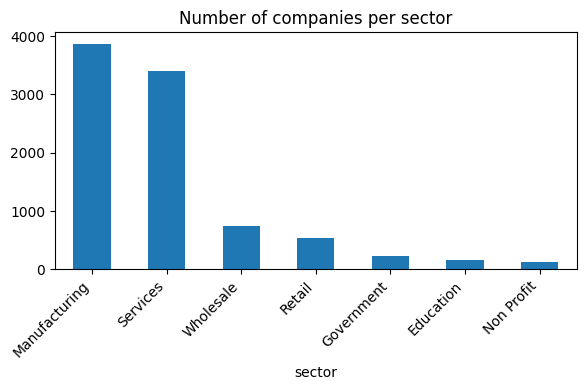

In [22]:

sector_counts = company_list_copy["sector"].value_counts()

plt.figure(figsize=(6,4))
sector_counts.plot(kind="bar")
plt.xticks(rotation=45, ha="right")
plt.title("Number of companies per sector")
plt.tight_layout()
plt.show()

This plot shows the 15 most frequent business categories in the dataset.
The largest category is *Farms & Agriculture Production*, followed by government,
chemical and industrial categories.

The chart confirms that a few categories concentrate a large number of companies,
while many other categories are less common. This imbalance is useful to keep in mind
when evaluating the classifier, because it will naturally see a lot more examples
from these dominant categories.

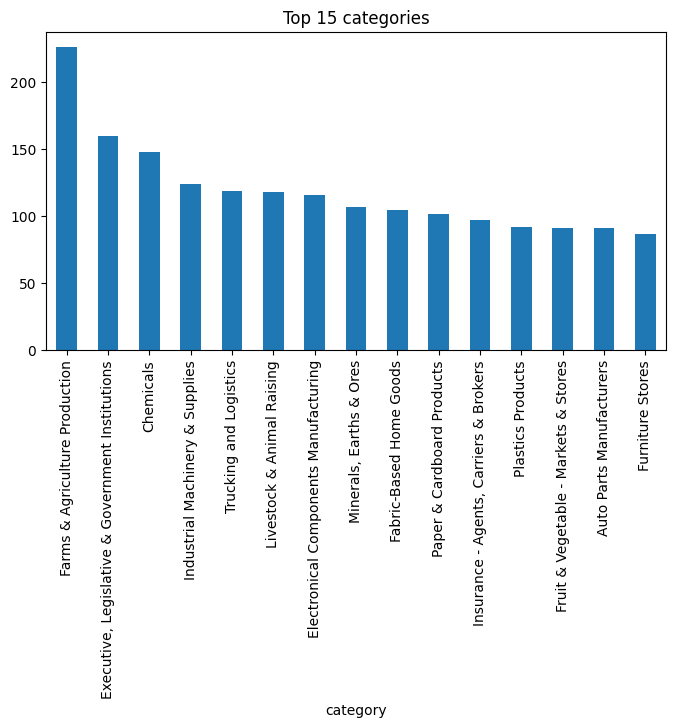

In [23]:
cat_counts = company_list_copy["category"].value_counts().head(15)

plt.figure(figsize=(8,6))
cat_counts.plot(kind="bar")
plt.xticks(rotation=90)
plt.title("Top 15 categories")
plt.subplots_adjust(bottom=0.35)
plt.show()

Next, I look at the length of the company descriptions.

The histogram below shows the distribution of description lengths (measured in characters).
Most descriptions are reasonably long, typically between ~200 and ~900 characters, which means
there is enough text for a TF–IDF based method to pick up useful signal. Very short descriptions
are rare, so I don’t expect text length to be a major limitation for the classifier.

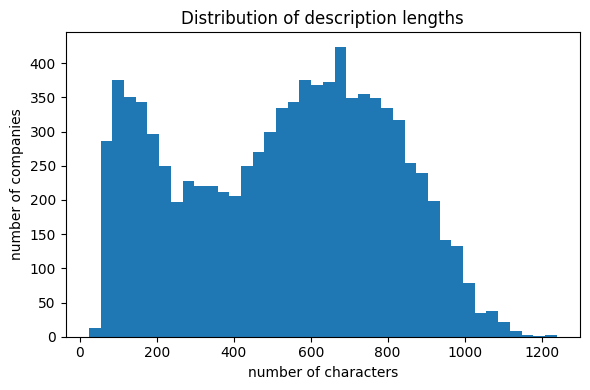

In [24]:
desc_len = company_list_copy["description"].astype(str).str.len()

plt.figure(figsize=(6,4))
plt.hist(desc_len, bins=40)
plt.title("Distribution of description lengths")
plt.xlabel("number of characters")
plt.ylabel("number of companies")
plt.tight_layout()
plt.show()

In [25]:
df = company_list_copy

## Building a single text field (`full_text`)

In this step, I combine all available textual information about each company into one column called `full_text`.
This includes the description, business tags, and the sector/category/niche fields.

The goal is to create a single input string per company so that the vectorization and similarity matching
can be applied consistently using one text representation.

In [26]:
df["full_text"] = (
    df["description"] + " " +
    df["business_tags"] + " " +
    df["sector"] + " " +
    df["category"] + " " +
    df["niche"]
)
df

,description,business_tags,sector,category,niche,full_text
0,Welchcivils is a civil engineering and constru...,"Construction Services, Multi-utilities, Utilit...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction,Welchcivils is a civil engineering and constru...
1,"Kyoto Vegetable Specialists Uekamo, also known...","Wholesale, Dual-task Movement Products, Cast I...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing","Kyoto Vegetable Specialists Uekamo, also known..."
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"Living Forms, Farm Cafe, Fresh Coffee, Communi...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming,Loidholdhof Integrative Hofgemeinschaft is a c...
3,PATAGONIA Chapa Y Pintura is an auto body shop...,"Automotive Body Repair Services, Interior Repa...",Services,Auto Body Shops,"Automotive Body, Paint, and Interior Repair an...",PATAGONIA Chapa Y Pintura is an auto body shop...
4,Stanica WODNA PTTK Swornegacie is a cultural e...,"Cultural Activities, Accommodation Services, K...",Services,Boat Tours & Cruises,"Scenic and Sightseeing Transportation, Water",Stanica WODNA PTTK Swornegacie is a cultural e...
...,...,...,...,...,...,...
9087,"Anhui Zhongxin Electric Co., Ltd. is a high-te...","Automation Equipment, Technical Consulting, Re...",Manufacturing,Electric Supplies & Power Generation,All Other Miscellaneous Electrical Equipment a...,"Anhui Zhongxin Electric Co., Ltd. is a high-te..."
9088,"TP Material Co.,Ltd. is a company based in the...","Construction Materials Supplier, Construction ...",Services,Construction Services,Commercial and Institutional Building Construc...,"TP Material Co.,Ltd. is a company based in the..."
9089,Aladiner Cherag is a company that offers a var...,"Fruit And Vegetables, Hand Wash Products, Meat...",Manufacturing,Dairy Products - Farms & Stores,Fluid Milk Manufacturing,Aladiner Cherag is a company that offers a var...
9090,Candor Eeg is a medical care company located i...,"Stress Tests, Hyperventilation, Holter Monitor...",Services,Radiology Clinic,Diagnostic Imaging Centers,Candor Eeg is a medical care company located i...


## TF–IDF vectorization and cosine similarity

Here I build a single corpus that contains:
- all company texts (`full_text`)
- all taxonomy labels (`label_text`)

I then apply TF–IDF to convert each text into a numeric vector representation.
After vectorization, I split the resulting matrix into:
- vectors for companies
- vectors for taxonomy labels

Finally, I compute cosine similarity between every company vector and every label vector.
This produces a similarity matrix (`sims`) where each row corresponds to a company and each column to a label.
Higher values mean the company text is more similar to that label.

In [27]:
labels_df = insurance_taxonomy.copy()
labels_df["label_text"] = labels_df["label"].fillna("")

In [28]:

corpus = list(df["full_text"]) + list(labels_df["label_text"])

vect = TfidfVectorizer(min_df=2, ngram_range=(1,2))
X = vect.fit_transform(corpus)

n_companies = len(df)
company_vecs = X[:n_companies]
label_vecs   = X[n_companies:]

sims = cosine_similarity(company_vecs, label_vecs)
sims

array([[0.00436557, 0.00385757, 0.0034029 , ..., 0.00400599, 0.00377873,
        0.00379617],
       [0.01747004, 0.        , 0.        , ..., 0.01168026, 0.        ,
        0.01106848],
       [0.00164385, 0.00145256, 0.00128136, ..., 0.00150845, 0.00142288,
        0.00142944],
       ...,
       [0.0034381 , 0.00303803, 0.00267995, ..., 0.00315492, 0.00297594,
        0.00298967],
       [0.00961982, 0.03123921, 0.02755723, ..., 0.00882747, 0.00832667,
        0.00836511],
       [0.029453  , 0.00348819, 0.00307706, ..., 0.0036224 , 0.0034169 ,
        0.00343267]])

## Selecting the final labels (top-K with a threshold)

Using the similarity matrix, I assign labels to each company as follows:

- I always keep the **top-1** label (the highest cosine similarity), so every company gets at least one label.
- I optionally add the **2nd and 3rd** labels, but only if their similarity score is above a chosen threshold (`threshold = 0.1`).
- I format the output as a single string, showing each label together with its similarity score
  (e.g. `Consulting Services (0.145)`).

This makes the predictions easier to interpret and prevents adding low-confidence labels.

In [29]:
top_k = 3
threshold = 0.1

labels_with_scores = []

for i in range(sims.shape[0]):
    row = sims[i]
    idx_sorted = np.argsort(-row)

    chosen = []

    j0 = idx_sorted[0]
    score0 = row[j0]
    label0 = labels_df["label"].iloc[j0]
    chosen.append(f"{label0} ({score0:.3f})")

    for j in idx_sorted[1:]:
        score = row[j]
        if score < threshold:
            break
        label = labels_df["label"].iloc[j]
        chosen.append(f"{label} ({score:.3f})")
        if len(chosen) == top_k:
            break

    labels_with_scores.append("; ".join(chosen))

df["insurance_labels"] = labels_with_scores


In [30]:
df[["description", "insurance_labels"]].head(10)

df.to_csv("companies_with_labels.csv", index=False)

In [32]:

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 50)

display(df[["sector", "category", "description", "insurance_labels"]].sample(20, random_state=0))


,sector,category,description,insurance_labels
221,Manufacturing,Auto Parts Manufacturers,"RSS / Road Sport Supply is a company that specializes in providing performance components for Porsche automobiles. They offer a wide range of products such as brake rotors, suspension components, ...",Road Maintenance Services (0.020)
5959,Government,Courthouses,"The City of Greenstone is a municipality located in the state of Georgia, United States. The city is known for its green spaces, parks, and outdoor recreation areas, and is home to the Greenstone ...",Waste Management Services (0.071)
154,Manufacturing,Breweries,Đại Lý Bia Nguyễn - Nhân Phân Đôn Phối Bia is a company that specializes in the production and distribution of beer.,Non-Alcoholic Beverage Manufacturing (0.073)
5741,Government,"Executive, Legislative & Government Institutions","The Jamaican Liaison Service, Canada, also known as JamaicaLiaisonservicecanada, is an agency established by the Ministry of Labour (Government of Jamaica) under the Memorandum of Understanding (M...",Agricultural Equipment Services (0.039)
1220,Manufacturing,Plastics Products,"Plasticoville is a company based in Joinville, Santa Catarina, Brazil, specializing in plastic fabrication.",Plastic Manufacturing (0.376); Plastic Signage Production (0.210)
384,Manufacturing,Fabric-Based Home Goods,"138°E Textile is a textile production company located in Nishikata-cho, a textile area in eastern Yamanashi Prefecture, Japan. The company specializes in producing original products such as ties, ...",Textile Manufacturing Services (0.271)
6571,Services,Glaziers & Glass Products,"Szikra-Glass Ltd is a company that specializes in safety glass products, tempered glass, glass space dividers, glass railings, glass cutting, and shower with glass walls. They offer a wide range o...",High-Rise Glass Installation (0.182); Low-Rise Glass Installation (0.172)
2999,Services,Tax Preparation,"Metley Accounting & Tax Services Brampton is a tax advisory company located in Brampton, Canada. They specialize in providing tax advice and services to individuals and businesses in the area. The...",HVAC Installation and Service (0.016)
23,Retail,Cosmetics Stores,"Gemini Beauty is a company that offers a variety of makeup, skincare, and hair products. Their makeup line includes items such as lip oil, liquid lipstick matte, liquid concealer, facial contour, ...",Oil and Fat Manufacturing (0.025)
776,Services,Shipping Couriers,"a.s is a Mexican company that specializes in the collection, encapsulation, and shipment of packaging materials.",Consulting Services (0.023)


## Most frequent predicted labels

After assigning labels to all companies, I analyze the distribution of predictions.
This bar chart shows the top 15 most common insurance labels produced by the model.

The goal is to check whether the classifier is overly biased toward a small set of labels
and to understand which labels dominate across the dataset.
If a few labels appear disproportionately often, it may indicate taxonomy imbalance
or that the model is matching many companies to very generic labels.

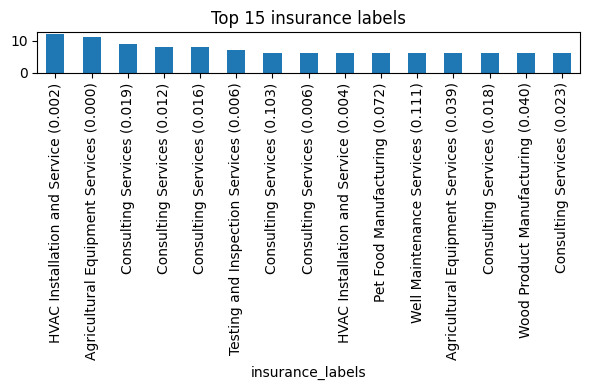

In [33]:

label_counts = (
    df["insurance_labels"]
      .str.split("; ")
      .explode()
      .value_counts()
      .head(15)
)

plt.figure(figsize=(6,4))
label_counts.plot(kind="bar")
plt.xticks(rotation=90)
plt.title("Top 15 insurance labels")
plt.tight_layout()
plt.show()


## Distribution of top-1 similarity scores

Here I plot the distribution of the highest cosine similarity score (top-1) for each company.
This gives a rough proxy for model confidence: higher top-1 scores usually mean the company text
matches a taxonomy label more clearly, while very low scores suggest weak or missing overlap.

This helps identify low-confidence cases where the taxonomy may not contain an appropriate label,
and where predictions can become unreliable.

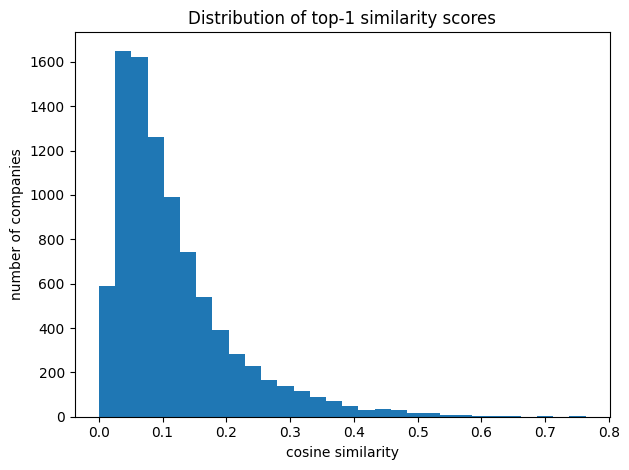

In [34]:
top1_scores = sims.max(axis=1)

plt.figure()
plt.hist(top1_scores, bins=30)
plt.title("Distribution of top-1 similarity scores")
plt.xlabel("cosine similarity")
plt.ylabel("number of companies")
plt.tight_layout()
plt.show()

## Example: top-3 labels for a single company

To make the similarity-based predictions more interpretable, I inspect one company at a time.
For the selected company `i`, I plot the top 3 labels with the highest cosine similarity scores.
This helps verify whether the model’s top candidates are reasonable and how strongly the best label
stands out compared to the next options.

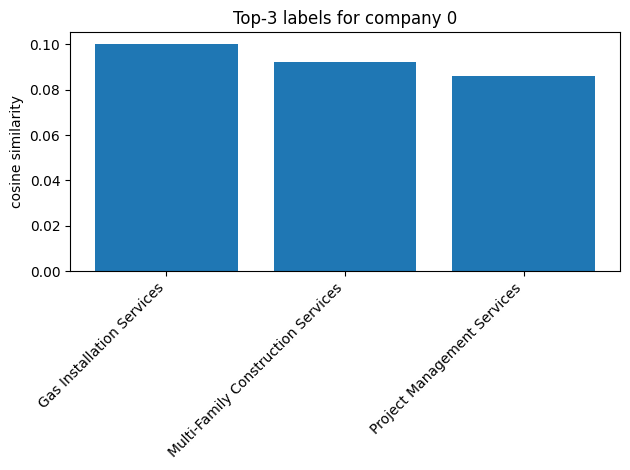

,0
description,Welchcivils is a civil engineering and construction company that specializes in designing and building utility network connections across the UK. They offer multi-utility solutions that combine el...
insurance_labels,Gas Installation Services (0.100)


In [35]:
i = 0

row = sims[i]
idx_sorted = np.argsort(-row)[:3]
labels_top3 = labels_df["label"].iloc[idx_sorted].tolist()
scores_top3 = row[idx_sorted]

plt.figure()
plt.bar(labels_top3, scores_top3)
plt.title(f"Top-3 labels for company {i}")
plt.xticks(rotation=45, ha="right")
plt.ylabel("cosine similarity")
plt.tight_layout()
plt.show()

df.iloc[i][["description", "insurance_labels"]]

## Identifying low-confidence predictions

Next, I flag companies where the best (top-1) cosine similarity score is very low (here `< 0.05`).
These cases are likely to be weak matches, often because the taxonomy does not contain a truly relevant label
for that company. This subset is useful for manual inspection and failure-case analysis.

In [36]:
top1_scores = sims.max(axis=1)
mask_low = top1_scores < 0.05
mask_low.sum()


np.int64(2169)

## Manual inspection of low-score examples

Here I create a small sample of companies with low top-1 similarity scores and attach the score to each row.
By randomly sampling a few of these cases, I can manually check what types of businesses appear here and
whether the predicted labels make sense.

This helps me understand the main failure modes of the approach (e.g., businesses that are not covered by the taxonomy).

In [37]:
sample_low = df.loc[mask_low, ["sector", "category", "description", "insurance_labels"]].copy()
sample_low["top1_score"] = top1_scores[mask_low]

sample_low.sample(20, random_state=0)

,sector,category,description,insurance_labels,top1_score
739,Manufacturing,Aircraft Parts & Services,"Take Flight 2 is a company that specializes in aircraft maintenance and conversions. They offer services for Cessna Cessnas, including engine and prop conversions, with a focus on improving fuel e...",Well Maintenance Services (0.042),0.041765
1611,Retail,Online Marketplace,1FastSales is a company that specializes in procuring trendy items for customers and their families. They have a team of experts who work tirelessly to find the latest products and ship them to cu...,Online Marketing Services (0.034),0.033590
1839,Wholesale,Auto Parts Manufacturers,"Auto Servis Dedja is a car factory located in Bulqizë, Dibër County, Albania.",New Ground Excavation (0.025),0.024517
7773,Manufacturing,Electronics Stores,"Handheld Radio Prc is a company that specializes in the production and distribution of various types of radio equipment and accessories. Their product line includes lithium batteries, TCAs, Dcs, V...",Agricultural Equipment Services (0.021),0.020802
7304,Services,Casino & Betting,"sfaapodcasts.net is a company that specializes in reviewing casino games. They provide information and reviews on various topics related to gaming, including football betting and slot machines. Th...",Online Marketing Services (0.040),0.039601
6760,Services,Cinemas & Video Theaters,"K.k.Emitra is a company based in Jhalawar, Rajasthan, India, specializing in computer networking services.",Consulting Services (0.031),0.031434
2424,Retail,Cigar & Tobacco Stores,"Huabei Building Famous Wine Town is a tobacco shop located in Zhangjiakou, Hebei, China.",Building Cleaning Services (0.022),0.021637
5540,Services,Book Publisher,Books by Bill is a company that specializes in children's books.,Children's Clothing Manufacturing (0.047),0.047143
5367,Manufacturing,Engines,"Shanghai Kogyo Bearing Co., Ltd. is a Chinese company that specializes in the import and export of bearings, including SKF, NSK, FAG, INA, NTN, IKO, KOYO, Timken, FYH, THK, Nachi, ZWZ, and ASAHI b...",Agricultural Equipment Services (0.028),0.028108
3748,Wholesale,Mining & Gas Exploration,Zambia China Economic & Trade Cooperation Zone (Zccz) is the first Chinese overseas economic and trade cooperation zone in Africa and the first multi-facility economic zone approved by the Zambian...,Sand and Gravel Mining (0.039),0.038851


## Worst-case analysis (lowest similarity scores)

In addition to random sampling, I also inspect the absolute worst cases by selecting the 20 companies
with the lowest top-1 similarity scores.

The goal is to understand what drives extremely low scores. In practice, these examples often have:
- very short or generic descriptions (little informative text), and/or
- business types that are not represented in the taxonomy, so there are no meaningful keyword overlaps.

These cases highlight an important limitation: if the taxonomy does not contain a suitable label for a company,
the similarity-based method cannot produce a reliable match.

In [38]:
idx_sorted_low = np.argsort(top1_scores)[:20]
df_low_worst = df.loc[idx_sorted_low, ["sector", "category", "description", "insurance_labels"]].copy()
df_low_worst["top1_score"] = top1_scores[idx_sorted_low]

df_low_worst

,sector,category,description,insurance_labels,top1_score
5451,Retail,Shoes & Other Footwear Stores,"Suwaik Al Wustha is a shoe store located in As Suwaiq, Al Batinah North Governorate, Oman.",Agricultural Equipment Services (0.000),0.000000
1807,Retail,Automobile Dealers & Manufacturers,"Subaru Seremban by SV Prestige Sdn Bhd is a Subaru dealership located in Seremban, Negeri Sembilan, Malaysia.",Agricultural Equipment Services (0.000),0.000000
3549,Retail,Shoes & Other Footwear Stores,"Show dos Calçados Asa Branca is a shoe store located in Boa Vista, Roraima, Brazil.",Agricultural Equipment Services (0.000),0.000000
1597,Retail,Shoes & Other Footwear Stores,"The MWalk Store is a shoe store located in Caieiras, São Paulo, Brazil.",Agricultural Equipment Services (0.000),0.000000
7068,Wholesale,Ophthalmic & Optical Instruments & Lenses,"OPTIC is an optical wholesaler located in Arlington, Texas. The company specializes in providing optical products to customers in the area.",Agricultural Equipment Services (0.000),0.000000
1491,Wholesale,Ophthalmic & Optical Instruments & Lenses,Óptica J.A. is an optical wholesaler located in Santa Cecilia.,Agricultural Equipment Services (0.000),0.000000
3035,Education,Language & Speaking Schools,"The company is an English language school located in Takamatsu, Kagawa Prefecture, Japan.",Agricultural Equipment Services (0.000),0.000000
3883,Wholesale,Handmade & Crafts Marketplace,"Sufiyan Handicrafts is a craft store located in Saharanpur, Uttar Pradesh, India.",Agricultural Equipment Services (0.000),0.000000
1118,Education,Driving Schools,"Barijotwa is a driving school located in Basti, Uttar Pradesh, India.",Agricultural Equipment Services (0.000),0.000000
3213,Retail,Watches & Jewelry Stores,"LAHU BENTEX JEWELLERS is a jewelry store located in Loni, Maharashtra, India.",Agricultural Equipment Services (0.000),0.000000


## Similarity score vs. text length

Here I test whether the length of the text (number of words in `full_text`) affects the similarity score.
The scatter plot shows that text length is not a strong driver of the top-1 similarity score.

In other words, low scores are not mainly caused by short descriptions. Instead, low-confidence predictions
typically happen when the company text does not share meaningful keywords with any taxonomy label
(i.e., the company’s business type is not covered by the taxonomy). In those cases the model is forced
to pick the “least bad” label, which can look random.

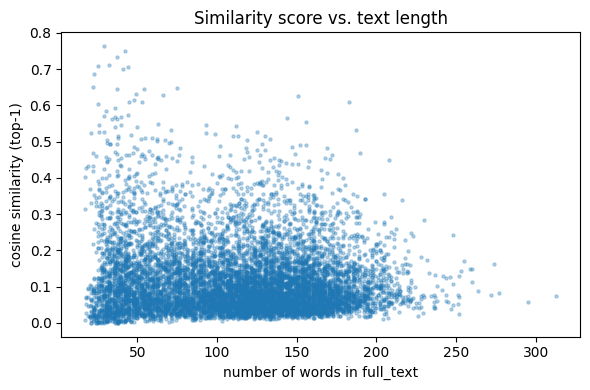

In [39]:
df["len_words"] = df["full_text"].astype(str).str.split().str.len()

top1_scores = sims.max(axis=1)

plt.figure(figsize=(6,4))
plt.scatter(df["len_words"], top1_scores, s=5, alpha=0.3)
plt.xlabel("number of words in full_text")
plt.ylabel("cosine similarity (top-1)")
plt.title("Similarity score vs. text length")
plt.tight_layout()
plt.show()

## Correlation between text length and similarity score

To quantify the relationship between text length and the top-1 similarity score, I compute the Pearson correlation.
A value close to 0 indicates there is little to no linear relationship, meaning that longer descriptions do not
automatically lead to higher similarity scores. This supports the conclusion that content overlap (keywords/terms)
matters more than text length.

In [40]:
np.corrcoef(df["len_words"], top1_scores)[0,1]


np.float64(-0.09531906862804337)

## Semantic embeddings baseline (Sentence Transformers)

After building a first baseline with TF–IDF + cosine similarity, I also tested a semantic approach based on text embeddings.
TF–IDF relies heavily on exact keyword overlap between the company text and the taxonomy labels. This can work well when
the same terms appear in both, but it may struggle for shorter descriptions or cases where the wording differs
(e.g., synonyms or different phrasing).

To address this, I use a pre-trained Sentence Transformer model (`all-MiniLM-L6-v2`) to convert both:
- each company `full_text`
- each taxonomy `label_text`

into dense semantic vectors. I then compute cosine similarity between company embeddings and label embeddings and select
the top-K labels (with a threshold) in the same way as the TF–IDF approach.

In [42]:

model = SentenceTransformer("all-MiniLM-L6-v2")

company_emb = model.encode(df["full_text"].tolist(), batch_size=64, show_progress_bar=True, normalize_embeddings=True)
label_emb   = model.encode(labels_df["label_text"].tolist(), batch_size=64, show_progress_bar=True, normalize_embeddings=True)

sims_emb = cosine_similarity(company_emb, label_emb)

top_k = 3
threshold_emb = 0.25

labels_with_scores_emb = []
for i in range(sims_emb.shape[0]):
    row = sims_emb[i]
    idx_sorted = np.argsort(-row)

    chosen = []
    j0 = idx_sorted[0]
    chosen.append(f"{labels_df['label'].iloc[j0]} ({row[j0]:.3f})")

    for j in idx_sorted[1:]:
        if row[j] < threshold_emb:
            break
        chosen.append(f"{labels_df['label'].iloc[j]} ({row[j]:.3f})")
        if len(chosen) == top_k:
            break

    labels_with_scores_emb.append("; ".join(chosen))

df["insurance_labels_emb"] = labels_with_scores_emb

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

## TF–IDF vs Embeddings: quick comparison

Here I compare the two approaches by checking whether they produce the same top-1 label.
I compute a simple agreement rate (percentage of companies where the top-1 label matches).

Then I inspect a small random sample of cases where the two methods disagree, to understand
what kinds of companies benefit from semantic embeddings versus lexical TF–IDF matching.

In [43]:
def first_label(s):
    if not isinstance(s, str) or s.strip() == "":
        return ""
    return s.split(";")[0].rsplit("(", 1)[0].strip()

df["top1_tfidf"] = df["insurance_labels"].apply(first_label)
df["top1_emb"]   = df["insurance_labels_emb"].apply(first_label)

agreement = (df["top1_tfidf"] == df["top1_emb"]).mean()
agreement

np.float64(0.24879014518257808)

In [44]:
diff = df[df["top1_tfidf"] != df["top1_emb"]]
diff[["sector","category","description","insurance_labels","insurance_labels_emb"]].sample(20, random_state=0)

,sector,category,description,insurance_labels,insurance_labels_emb
2364,Services,Research Institutes,Ekonomi Koperasi is a company based in Indonesia that focuses on analyzing and discussing the country's political and economic policies and strategies. They aim to shed light on the country-wide p...,Consulting Services (0.077),Strategic Planning Services (0.241)
673,Services,Asphalt & Paving Services,"Tar Surfacing and Paving is a local business based in Brakpan, Johannesburg, South Africa. Established in 2015, the company is committed to providing high-quality services and products to ensure c...",Commercial Driveway Construction (0.127); Asphalt Production Services (0.117); Residential Driveway Construction (0.102),Road Maintenance Services (0.494); Asphalt Production Services (0.490); Excavation Services (0.465)
6647,Manufacturing,Electronics Stores,"Jabra is a Japanese company that specializes in the production and sale of hearing aids. They offer a wide range of products, including wired and wireless headsets, sports headsets, office headset...",Alarm Installation Services (0.032),Residential Communication Equipment Installation (0.270); Mobile Home Construction Services (0.270); Commercial Communication Equipment Installation (0.251)
1491,Wholesale,Ophthalmic & Optical Instruments & Lenses,Óptica J.A. is an optical wholesaler located in Santa Cecilia.,Agricultural Equipment Services (0.000),Graphic Design Services (0.280); Commercial Electrical Services (0.268); Quality Assurance Services (0.264)
5030,Services,Dry Cleaners,"Wash-Brite Laundry is a laundromat located in Brownwood, Texas, United States.",Consulting Services (0.019),Street Cleaning Operations (0.321); Waste Management Services (0.299); Building Cleaning Services (0.298)
3929,Services,Funeral Services & Cemeteries,"The company is categorized under cremation services and is located in Hoshiarpur, Punjab, India.",Consulting Services (0.033),Catering Services (0.372); Corporate Responsibility Services (0.366); Waste Management Services (0.363)
2643,Services,Landscaping & Lawn Services,"La Mesa Artificial Grass is a synthetic turf installation company based in La Mesa, California. They specialize in the installation of landscape turf, pet turf, playground turf, and golf putting g...",Flooring Installation Services (0.099),Sidewalk Construction Services (0.367); Asphalt Production Services (0.358); Carpet Manufacturing Services (0.349)
6586,Wholesale,"Meat, Fish & Seafood Stores","Savant Consult Malaysia SB, also known as Flex Trade PVT LTD, is a food and essentials exporter, procurement representative, and logistics solution provider. Established in 2019, the company was f...",Window and Door Manufacturing (0.086),Gas Manufacturing Services (0.415); Meat Processing Services (0.411); Consulting Services (0.407)
3364,Manufacturing,Engines,"Shenyang Hu Jingan Precision Bearing Manufacturing Co., Ltd. is a professional bearing manufacturing supplier that has been in close cooperation with SKF and other well-known manufacturers for man...",Plastic Manufacturing (0.022),Grain Handling Machinery Installation (0.360); Wood Product Manufacturing (0.347); Trim Manufacturing (0.342)
6544,Services,Auto Services,"Sto Mekhanich is a company based in Krasnodar, Russia, specializing in car repair and maintenance services.",Well Maintenance Services (0.252); Boiler Repair Services (0.145); Road Maintenance Services (0.144),Road Maintenance Services (0.334); Boiler Repair Services (0.309); Asphalt Production Services (0.304)


Here I plot the distribution of top-1 cosine similarity scores produced by the embedding model.
This helps set a confidence threshold for embeddings and highlights the low-confidence tail of predictions.

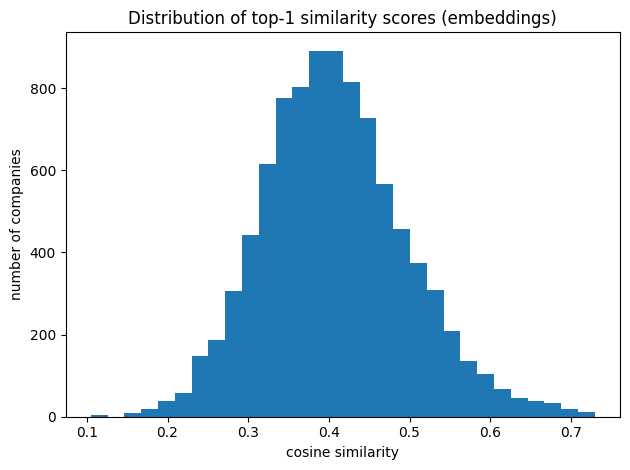

In [45]:

top1_scores_emb = sims_emb.max(axis=1)

plt.figure()
plt.hist(top1_scores_emb, bins=30)
plt.title("Distribution of top-1 similarity scores (embeddings)")
plt.xlabel("cosine similarity")
plt.ylabel("number of companies")
plt.tight_layout()
plt.show()


## Comparing embeddings on the worst TF–IDF cases

In this step I focus on the 40 companies with the lowest TF–IDF top-1 similarity scores (i.e., the weakest lexical matches).
I then compare, side by side, what TF–IDF predicts versus what the embedding-based approach predicts for the same companies.

For each of these worst TF–IDF examples, I also attach:
- `top1_tfidf`: the best TF–IDF similarity score
- `top1_emb`: the best embedding similarity score

This analysis helps me understand whether embeddings provide more meaningful labels when TF–IDF fails,
and it highlights cases where both methods struggle due to limited taxonomy coverag

In [46]:
top1_tfidf = sims.max(axis=1)
top1_emb   = sims_emb.max(axis=1)

idx_worst_tfidf = np.argsort(top1_tfidf)[:40]

compare_worst = df.loc[idx_worst_tfidf, ["sector","category","description","insurance_labels","insurance_labels_emb"]].copy()
compare_worst["top1_tfidf"] = top1_tfidf[idx_worst_tfidf]
compare_worst["top1_emb"]   = top1_emb[idx_worst_tfidf]

compare_worst

,sector,category,description,insurance_labels,insurance_labels_emb,top1_tfidf,top1_emb
5451,Retail,Shoes & Other Footwear Stores,"Suwaik Al Wustha is a shoe store located in As Suwaiq, Al Batinah North Governorate, Oman.",Agricultural Equipment Services (0.000),Apparel Manufacturing (0.287),0.000000,0.286862
1807,Retail,Automobile Dealers & Manufacturers,"Subaru Seremban by SV Prestige Sdn Bhd is a Subaru dealership located in Seremban, Negeri Sembilan, Malaysia.",Agricultural Equipment Services (0.000),Livestock Dealer Services (0.248),0.000000,0.248251
3549,Retail,Shoes & Other Footwear Stores,"Show dos Calçados Asa Branca is a shoe store located in Boa Vista, Roraima, Brazil.",Agricultural Equipment Services (0.000),Livestock Dealer Services (0.274); Apparel Manufacturing (0.257),0.000000,0.273800
1597,Retail,Shoes & Other Footwear Stores,"The MWalk Store is a shoe store located in Caieiras, São Paulo, Brazil.",Agricultural Equipment Services (0.000),Apparel Manufacturing (0.290),0.000000,0.289775
7068,Wholesale,Ophthalmic & Optical Instruments & Lenses,"OPTIC is an optical wholesaler located in Arlington, Texas. The company specializes in providing optical products to customers in the area.",Agricultural Equipment Services (0.000),Graphic Design Services (0.283); Apparel Manufacturing (0.281),0.000000,0.283038
1491,Wholesale,Ophthalmic & Optical Instruments & Lenses,Óptica J.A. is an optical wholesaler located in Santa Cecilia.,Agricultural Equipment Services (0.000),Graphic Design Services (0.280); Commercial Electrical Services (0.268); Quality Assurance Services (0.264),0.000000,0.280459
3035,Education,Language & Speaking Schools,"The company is an English language school located in Takamatsu, Kagawa Prefecture, Japan.",Agricultural Equipment Services (0.000),Corporate Training Services (0.326); Technology Consulting (0.281); Management Consulting (0.277),0.000000,0.326374
3883,Wholesale,Handmade & Crafts Marketplace,"Sufiyan Handicrafts is a craft store located in Saharanpur, Uttar Pradesh, India.",Agricultural Equipment Services (0.000),Textile Manufacturing Services (0.423); Apparel Manufacturing (0.364); Accessory Manufacturing (0.345),0.000000,0.422511
1118,Education,Driving Schools,"Barijotwa is a driving school located in Basti, Uttar Pradesh, India.",Agricultural Equipment Services (0.000),Coffee Processing Services (0.250),0.000000,0.250091
3213,Retail,Watches & Jewelry Stores,"LAHU BENTEX JEWELLERS is a jewelry store located in Loni, Maharashtra, India.",Agricultural Equipment Services (0.000),Accessory Manufacturing (0.262); Apparel Manufacturing (0.250),0.000000,0.262308


## Hybrid strategy (TF–IDF + embeddings)

TF–IDF performs best when there is strong keyword overlap between the company text and a taxonomy label.
Embeddings can help when the overlap is weak but the meaning is still related.

To combine both strengths, I use a simple hybrid rule:
- if the TF–IDF top-1 score is above a cutoff, I trust TF–IDF (lexical match)
- otherwise, I fall back to embeddings (semantic match)

This keeps TF–IDF’s precision on clear matches while improving coverage on harder cases.

In [47]:
top1_tfidf = sims.max(axis=1)
top1_emb   = sims_emb.max(axis=1)

tfidf_cutoff = 0.10
emb_cutoff   = 0.25

df["insurance_labels_final"] = np.where(
    top1_tfidf >= tfidf_cutoff,
    df["insurance_labels"],
    np.where(
        top1_emb >= emb_cutoff,
        df["insurance_labels_emb"],
        "Unknown"
    )
)

df["top1_tfidf_score"] = top1_tfidf
df["top1_emb_score"]   = top1_emb

With the chosen thresholds (`tfidf_cutoff = 0.10`, `emb_cutoff = 0.25`), 231 companies are marked as `Unknown`.
These are typically cases where neither TF–IDF nor embeddings find a confident match, often because the business type is not well covered by the provided taxonomy.

In [48]:
(df["insurance_labels_final"] == "Unknown").sum()


np.int64(231)

## Inspecting `Unknown` predictions with both methods

For transparency, I inspect a sample of companies marked as `Unknown` and display:
- the TF–IDF prediction and its top-1 score
- the embedding-based prediction and its top-1 score

This helps confirm that these cases are genuinely low-confidence or mismatched, and that forcing a label
would likely be misleading (often due to missing coverage in the taxonomy).

From manual inspection, I noticed that embedding-based predictions in the ~0.20–0.25 range can sometimes look
*partially* reasonable, but they still do not accurately represent the company’s true business type.
In these cases, the model is essentially picking the closest available label rather than a truly correct one.

For TF–IDF, very low similarity scores (close to 0) usually indicate little to no keyword overlap with any label,
so the resulting match is often not meaningful and should be treated as low-confidence.

In [49]:
unknown_view = df[df["insurance_labels_final"]=="Unknown"][
    ["sector","category","description",
     "insurance_labels","insurance_labels_emb",
     "top1_tfidf_score","top1_emb_score"]
].sample(20, random_state=0)

unknown_view

,sector,category,description,insurance_labels,insurance_labels_emb,top1_tfidf_score,top1_emb_score
8423,Education,"Learning, Tutoring & Courses",Root (Root) is a small-group unit study center located at Fujimidai Station on the Seibu Ikebukuro Line of Keihan Railway that provides individual and group tutoring for university and high school...,High-Rise Foundation Construction (0.033),Training Services (0.242),0.033208,0.242163
5348,Services,Casino & Betting,"Royalwin is a gaming company that offers a variety of slot machines, including HS, HS, RG, RG+, NLC, NLC+, QT, QT Slot, AE, LGD, AG, AG Slot, YGG, and YGG Slot. They also provide a range of games ...",Online Marketing Services (0.038),Sports Management Services (0.245),0.037617,0.244818
6697,Wholesale,Chemicals,"Selcote Africa Selenium granules, also known as Selcote Ultra, is a company that specializes in the production and distribution of Selcete Ultra, a natural product that boosts selenium levels. Sel...",Online Marketing Services (0.026),Textile Manufacturing Services (0.237),0.025852,0.237156
7201,Non Profit,Churches & Religious Organizations,Ohr Yeshua Messianic Synagogue is a religious organization that believes in unity among its members and presents its witness of Yeshua (Jesus) the Messiah as those who walk in His light. They beli...,Non-Profit Management (0.089),Volunteer Services (0.241),0.089064,0.241226
4930,Education,Flight Training,Makeda is a Russian-based company that offers a unique membership program for individuals interested in learning to fly. The program is based on a fly-free school environment and requires no prior...,Non-Profit Management (0.065),Pet Boarding Services (0.239),0.065464,0.239127
4767,Services,Book Publisher,Kabbalah Keys is a company that focuses on the belief that there is a boundless force hidden within the cosmos waiting to be unleashed. They believe that the motherlode of this energy is contained...,Animal Day Care Services (0.019),Community Engagement Services (0.196),0.019387,0.195905
5553,Services,"Alarms, Surveillance & Security Systems","California Car Concierge is a group of car enthusiasts who share a passion for cars. They have a diverse collection of rare and vintage cars, as well as modern-day models, and enjoy showing them o...",Animal Day Care Services (0.043),Interior Design Services (0.230),0.042901,0.230159
6498,Retail,Musical Instruments & Music Stores,"Kannapianokyoshitsu Kaiga School is an educational institution located in Tsukuba, Ibaraki Prefecture, Japan. It specializes in providing piano instruction and adult education.",Arts Services (0.055),Training Services (0.200),0.054500,0.200198
3495,Government,"Executive, Legislative & Government Institutions","The Orenburg UFAO, or the Federal Antimonopoly Service of the Russian Federation, is a regulatory body responsible for overseeing competition and competition in the Orenberg region of Russia. It o...",Data Analysis Services (0.054),Human Resources Services (0.234),0.054471,0.234128
5926,Services,Cinemas & Video Theaters,"Cine y Teatro Aya Hatariy is a theater company located in Carcelén Alto, Quito, Ecuador. They offer a variety of theatrical performances and provide updates on their programming through their webs...",Ice Production Services (0.084),Media Production Services (0.245),0.083864,0.244591


## Final output

This is the final hybrid model output, after all preprocessing and post-processing steps.
The annotated dataset is saved as a CSV file with the final column `insurance_labels_final`.

In [58]:
final_cols = ["description", "business_tags", "sector", "category", "niche", "insurance_labels"]
df[final_cols].to_csv("companies_with_labels.csv", index=False)


In [59]:
files.download("companies_with_labels.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>